<h2>Analysis of 11 June 2015 event in PECAN</h2>
<h3>using PyTDA, Py-ART, and AWOT</h3>

<b>Author</b><br>
Nick Guy

<b>Overview</b><br>
On 11 June 2015 during the PECAN field campaign, the UWyo King Air aircraft encountered severe turbulence followed by a large negative G "slap". The research aircraft provides a unique dataset to compare to the Python Turbulence Detection Algorithm (PyTDA) results using the NEXRAD (88D) network of radars.

This notebook relies heavily on the example presented by Timothy Lang during the AMS Open Source short course during the 37th AMS Radar Conference and extends to a case study of this event.

In [1]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import pyart
import pytda
import awot
import pyradarmet
from awot.graph import create_basemap, FlightLevel, RadarHorizontalPlot
%matplotlib inline

Open the NEXRAD files using Py-ART and load the UWKA flight data using AWOT.<br><br>
There were two NEXRAD radars with view of this system - KTWX and KUEX, located in Topeka, KS and Grand Island, NE, respectively. We will load both radar instances, but only use KUEX as this radar was better located with respect to the storm position and was nearer to the UWyo King Air at the time severe turbulence was encountered.<br><br>

A plot of KTWX later does show that an enhanced turbulence signal was observed in this data as well.

In [2]:
fdir = '/Users/guy/data/pecan'
filesKTWX = glob.glob(os.path.join(fdir, 'nex2', 'ktwx', '*V06*'))
filesKUEX = glob.glob(os.path.join(fdir, 'nex2', 'kuex', '*V06*'))
print(filesKTWX[5])
print(filesKUEX[6])

/Users/guy/data/pecan/nex2/ktwx/KTWX20150611_031725_V06.gz
/Users/guy/data/pecan/nex2/kuex/KUEX20150611_031925_V06.gz


In [3]:
def read_l2_gzip(filename):
    print(os.path.basename(filename[:-3]))
    if filename[-3:] == '.gz':  # likely gzipped
        os.system('gzip -d '+filename)
        radar = pyart.aux_io.read_radx(filename[:-3])
        os.system('gzip '+filename[:-3])
    else:  # likely not gzipped
        radar = pyart.aux_io.read_radx(filename)
        os.system('gzip '+filename)
    return radar

In [4]:
# KTWX
radarKTWX = read_l2_gzip(filesKTWX[5])
# KUEX
# We are using AWOT to read the file here, which keeps the original Py-ART instance 
# when `map_to_awot' is set to False
#radarKUEX = awot.io.read_ground_radar(filesKUEX[6], map_to_awot=False)
#radarntda = awot.io.read_ground_radar(filesKUEX[6], map_to_awot=False)
radarKUEX = read_l2_gzip(filesKUEX[6])
#radarntda = read_l2_gzip(filesKUEX[6])

# For use later
radarKUEXb = read_l2_gzip(filesKUEX[8])
radarKUEXawot = awot.io.read_ground_radar(filesKUEX[6], map_to_awot=True)

KTWX20150611_031725_V06
KUEX20150611_031925_V06
KUEX20150611_032842_V06


Read the UWKA flight data file using AWOT, first provide a mapping dictionary as default is slightly different for this file.

In [5]:
name_map = {
#        'time': 'time',
            # Aircraft Position
            'longitude': 'LONC',
            'latitude': 'LATC',
            'altitude': 'ztrue',
            'pressure_altitude': 'PALT',
            'tas': 'tas',
            'ias': 'aias',
            'true_heading': 'AVthead',
            'pitch': 'AVpitch',
            'roll_angle': 'AVroll',
            # Atmospheric State
            'pressure': 'pmb',
            'temperature': 'trf',
            'dewpoint_temperature': 'tdplicor',
            'thetad': 'thetad',
            'thetae': 'thetae',
            'relative_humidity': 'rh',
            'mixing_ratio': 'mr',
            'lwc': 'lwc100',
            'turb': 'turb',
            'g_accel': 'avnorma',
            # Radiometric
            'irtop': 'irtc',
            'irbottom': 'irbc',
            'swtop': 'swt',
            'swbottom': 'swb',
            # Wind derivations
            'Uwind': 'avuwind',
            'Vwind': 'avvwind',
            'Wwind': 'avwwind',
            'longitudinal_wind': 'avux',
            'latitudinal_wind': 'avvy',
            'wind_dir': 'avwdir',
            'wind_spd': 'axwmag',
            # Licor Concentrations
            'co2_conc': 'co21s',
            'h2o_conc': 'h2o1s',
            # Aerosol
            'pcasp_num': 'AS200_OBR',
            'pcasp_conc': 'CS200_OBR',
            'pcasp_mean_diam': 'DBARP_OBR',
            'pcasp_surf_area_conc': 'PSFCP_OBR',
            'pcasp_vol_conc': 'PVOLP_OBR',
            # Cloud Physics
            'conc_cpc': 'cpc_conc',
            # Miscellaneous
            'topo': 'topo'}

flight = awot.io.read_netcdf(os.path.join(fdir, '20150611.c50.nc'), mapping_dict=name_map)
flight1Hz = awot.io.read_netcdf(os.path.join(fdir, '20150611.c1.nc'), mapping_dict=name_map)

Using 'time' to make AWOT time variable
Using 'time' to make AWOT time variable


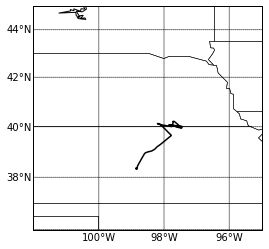

In [6]:
bm = create_basemap(corners=[-102., 36., -95., 45.], proj='cea', resolution='l')
bm.drawstates()
fl = FlightLevel(flight, basemap=bm)
fl.plot_trackmap()

Now calculate the turbulence from the radar volume.

The default is to do fuzzy-logic-based QC on the turbulence retrievals, to ensure better quality. This is like what the NCAR Turbulence Detection Algorithm (NTDA) does. However, there is an option to turn that off and just have straight inversion of spectrum width to EDR. You can use the verbose keyword to turn off the text, I just turned it on to show more of what was going on. See the documentation below to find out all the different keyword options.

In [6]:
bwKTWX = radarKTWX.instrument_parameters['radar_beam_width_h']['data'][0]
bwKUEX = radarKUEX.instrument_parameters['radar_beam_width_h']['data'][0]

In [8]:
# Run PyTDA on the KTWX radar instance
pytda.calc_turb_vol(radarKTWX, name_sw='SW', name_dz='REF', verbose=False,
                    gate_spacing=250.0/1000.0, use_ntda=False, beamwidth=bwKTWX)

In [7]:
# Run PyTDA on the KUEX radar instance
pytda.calc_turb_vol(radarKUEX, name_sw='SW', name_dz='REF', verbose=False,
                    gate_spacing=250.0/1000.0, use_ntda=False, beamwidth=bwKUEX)

In [10]:
# Run PyTDA on a volume 10 minutes later than peak time
pytda.calc_turb_vol(radarKUEXb, name_sw='SW', name_dz='REF', verbose=False,
                    gate_spacing=250.0/1000.0, use_ntda=False, beamwidth=bwKUEX)

In [8]:
# Run PyTDA on 
pytda.calc_turb_vol(radarKUEX, name_sw='SW', name_dz='REF', verbose=False,
                    gate_spacing=250.0/1000.0, use_ntda=True, beamwidth=bwKUEX)

/Users/guy/anaconda/lib/python2.7/site-packages/pytda-1.0-py2.7-macosx-10.5-x86_64.egg/pytda/pytda.py:280: RuntimeWarning: invalid value encountered in sqrt


Set up some plot list functions that produce multipanel plots using Py-ART functions.

In [9]:
def plot_list_of_fields(radar, sweep=0, fields=['reflectivity'], vmins=[0],
                        vmaxs=[65], units=['dBZ'], cmaps=['RdYlBu_r'],
                        return_flag=False, xlim=[-150, 150], ylim=[-150, 150],
                        mask_tuple=None):
    num_fields = len(fields)
    if mask_tuple is None:
        mask_tuple = []
        for i in np.arange(num_fields):
            mask_tuple.append(None)
    nrows = (num_fields + 1) // 2
    ncols = (num_fields + 1) % 2 + 1
    fig = plt.figure(figsize=(14.0, float(nrows)*5.5))
    display = pyart.graph.RadarDisplay(radar)
    for index, field in enumerate(fields):
        ax = fig.add_subplot(nrows, 2, index+1)
        display.plot_ppi(field, sweep=sweep, vmin=vmins[index],
                         vmax=vmaxs[index],
                         colorbar_label=units[index], cmap=cmaps[index],
                         mask_tuple=mask_tuple[index])
        display.set_limits(xlim=xlim, ylim=ylim)
    plt.tight_layout()
    if return_flag:
        return display
    
def plot_list_of_fields_to_map(radar, sweep=0, fields=['reflectivity'], vmins=[0],
                        vmaxs=[65], units=['dBZ'], cmaps=['RdYlBu_r'],
                        return_flag=False, lonlim=[-180, 180], latlim=[-90, 90],
                        projection='lcc', resolution='l',
                        mask_tuple=None, plot_track=False, flight=None,
                        start_time=None, end_time=None,
                        plot_time_stamps=False, timestep=600):
    num_fields = len(fields)
    if mask_tuple is None:
        mask_tuple = []
        for i in np.arange(num_fields):
            mask_tuple.append(None)
    nrows = (num_fields + 1) // 2
    ncols = (num_fields + 1) % 2 + 1
    fig = plt.figure(figsize=(14.0, float(nrows)*5.5))
    mapdisplay = pyart.graph.RadarMapDisplay(radar)
    for index, field in enumerate(fields):
        ax = fig.add_subplot(nrows, 2, index+1)
        mapdisplay.plot_ppi_map(field, sweep, vmin=vmins[index], vmax=vmaxs[index],
                     min_lon=lonlim[0], max_lon=lonlim[1], 
                     min_lat=latlim[0], max_lat=latlim[1],
                     cmap=cmaps[index],
                     projection=projection, resolution=resolution,
                     lat_0=radar.latitude['data'][0],
                     lon_0=radar.longitude['data'][0])
        if plot_track:
            f2 = FlightLevel(flight, basemap=mapdisplay.basemap)
            f2.plot_trackmap(min_altitude=50., lw=2.5,
                            start_time=start_time, end_time=end_time)
        if plot_time_stamps:
            f2.time_stamps(start_time=start_time, end_time=end_time,
                           labelspacing=timestep)
    plt.tight_layout()
    if return_flag:
        return mapdisplay

First let's take a look at the overall system structure and plot out reflectivity, radial velocity, spectrum width, and the calculated turbulence term from PyTDA. The morphology may be considered to be a quasi-linear MCS. This particular syatem had "fingers" extending to the South-Southeast, where vigorous convection was initiating. The system was extremely electrically active. In lower panels where the aircraft track is plotted, the most electrically active area was N-NE of the aircraft.

/Users/guy/anaconda/lib/python2.7/site-packages/matplotlib/colors.py:584: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


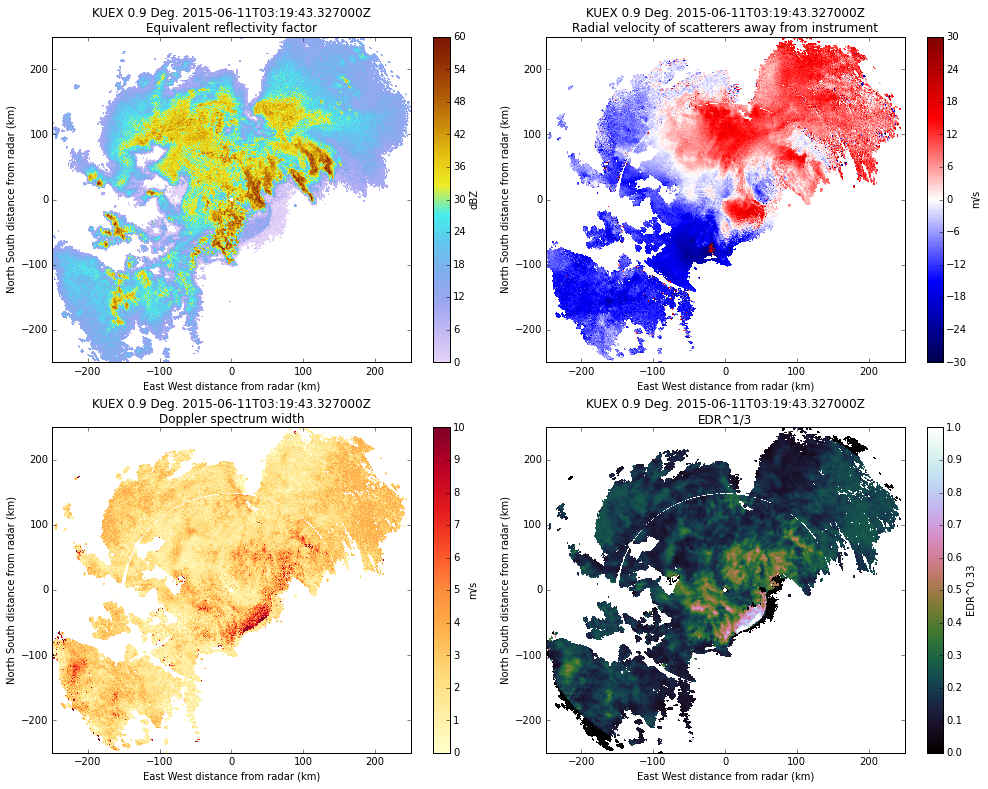

In [13]:
plot_list_of_fields(radarKUEX, sweep=1, xlim=[-250, 250], ylim=[-250, 250],
                    fields=['REF', 'VEL', 'SW', 'turbulence'],
                    vmins=[0, -30, 0, 0], vmaxs=[60, 30, 10, 1.0], 
                    units=['dBZ', 'm/s', 'm/s', 'EDR^0.33'],
                    cmaps=['pyart_LangRainbow12', 'seismic', 'YlOrRd', 'cubehelix'])

This next image is from the KTWX radar, with the UWyo King Ait track on top to show that enhanced turbulence was detected. The image is from 0317 UTC, 4 minutes before the severe turbulence event was encountered. As explained above analysis will not involve this radar.

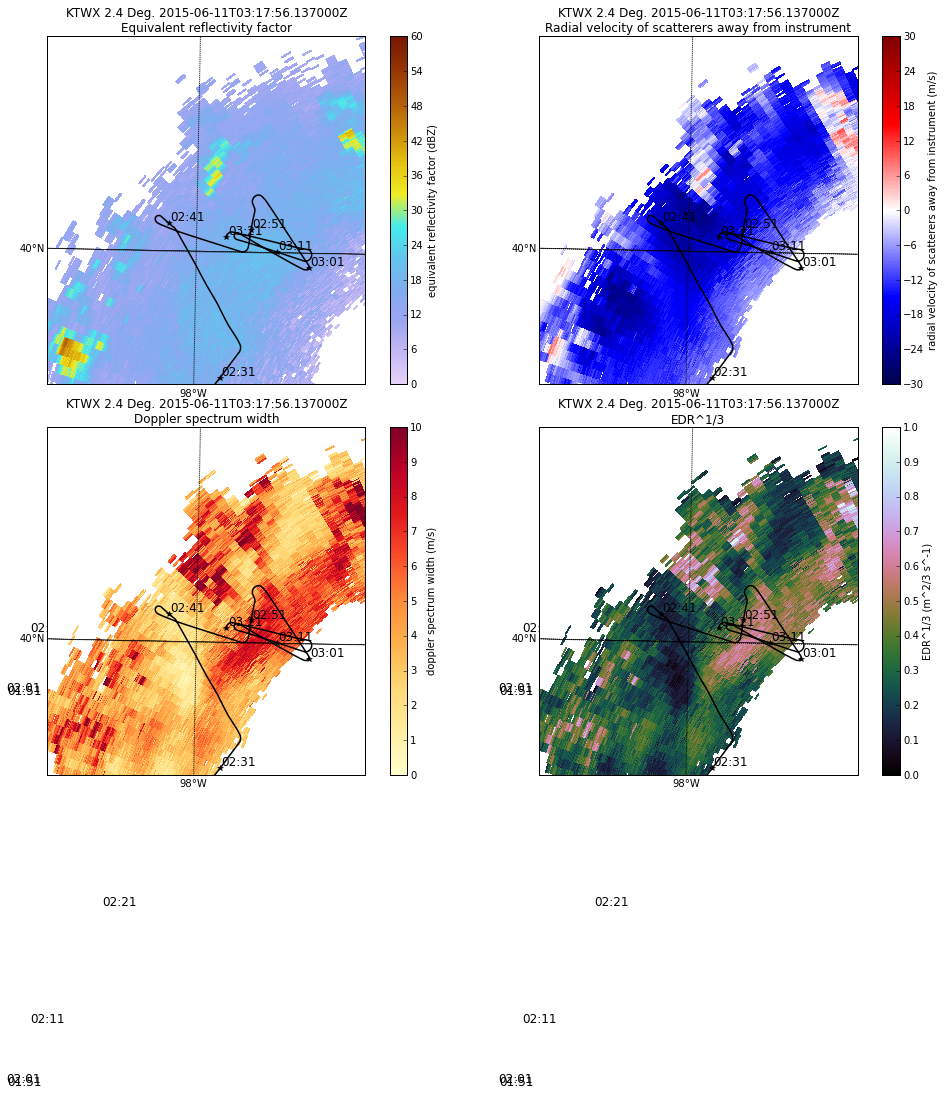

In [14]:
plot_list_of_fields_to_map(radarKTWX, sweep=2, 
                    lonlim=[-98.7, -97.2], latlim=[39.5, 40.8],
                    fields=['REF', 'VEL', 'SW', 'turbulence'],
                    vmins=[0, -30, 0, 0], vmaxs=[60, 30, 10, 1.0], 
                    units=['dBZ', 'm/s', 'm/s', 'EDR^0.33'],
                    cmaps=['pyart_LangRainbow12', 'seismic', 'YlOrRd', 'cubehelix'],
                    plot_track=True, flight=flight1Hz, plot_time_stamps=True)
#                     projection='lcc', resolution='h',

Let's take a quick look at the flight data leading up the event and plot some time series

In [15]:
flight_subset = ["2015-06-11 03:10:00", "2015-06-11 03:24:00"]
flight['turb']['data'].shape

(5404,)

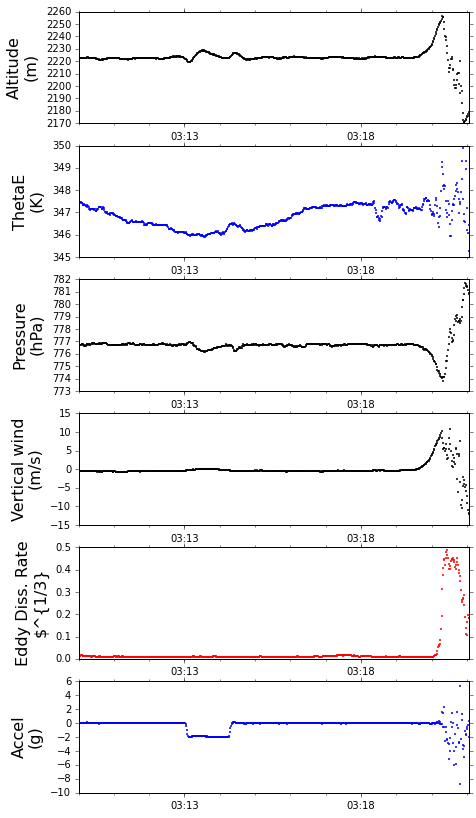

In [16]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1, figsize=(7, 14))
fl = FlightLevel(flight1Hz, basemap=None)
fl.plot_timeseries('altitude', color='k', marker='o', msize=1.5, lw=2,
                    dForm='%H:%M', tz=None, xdate=True,
#                    date_MinTicker='minute', other_MajTicks=None, other_MinTicks=None,
#                    other_min=None, other_max=None, 
                    start_time=flight_subset[0], end_time=flight_subset[1],
                    title=None, ylab='Altitude\n(m)', ax=ax1)

fl.plot_timeseries('thetae', color='b', ylab='ThetaE\n(K)', 
                    start_time=flight_subset[0], end_time=flight_subset[1], ax=ax2)
fl.plot_timeseries('pressure', color='k', ylab='Pressure\n(hPa)', 
                    start_time=flight_subset[0], end_time=flight_subset[1], ax=ax3)
fl.plot_timeseries('Wwind', color='k', ylab='Vertical wind\n(m/s)',
                    start_time=flight_subset[0], end_time=flight_subset[1], ax=ax4)
fl.plot_timeseries('turb', color='r', ylab='Eddy Diss. Rate\n$^{1/3}',
                    start_time=flight_subset[0], end_time=flight_subset[1], ax=ax5)
fl.plot_timeseries('g_accel', color='b', ylab='Accel\n(g)',
                    start_time=flight_subset[0], end_time=flight_subset[1], ax=ax6)

Now let's find out the height of our radar beam at various elevation angles in the radar volume using the Haversine formula. From the results below sweep 2 is the closest in height, therefore we will use this for analysis.

In [17]:
#print(radarKUEX.elevation['data'][radarKUEX.sweep_start_ray_index['data'][:]])
#print(radarKUEX.elevation['data'][radarKUEX.sweep_end_ray_index['data'][:]])

lat1, lon1 = radarKUEX.latitude['data'][0], radarKUEX.longitude['data'][0]
lat2, lon2 = flight['latitude']['data'][-1], flight['longitude']['data'][-1]
delLat = lat1 - lat2
delLon = lon1 - lon2
R = 6371000.
print("Radar Lat: %g, Aircraft Lat: %g"%(lat1, lat2))
print("Radar Lon: %g, Aircraft Lon: %g"%(lon1, lon2))
a = (np.sin(np.radians(delLat)/2))**2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * (np.sin(np.radians(delLon)/2))**2
c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
d = R * c 

#elev3 = radarKUEX.elevation['data'][radarKUEX.sweep_end_ray_index['data'][3]]
#elev4 = radarKUEX.elevation['data'][radarKUEX.sweep_end_ray_index['data'][4]]
#elev5 = radarKUEX.elevation['data'][radarKUEX.sweep_end_ray_index['data'][5]]

#beam_height3 = pyradarmet.geometry.ray_height(d, elev3, radar.altitude['data'][0])
#beam_height4 = pyradarmet.geometry.ray_height(d, elev4, radar.altitude['data'][0])
#beam_height5 = pyradarmet.geometry.ray_height(d, elev5, radar.altitude['data'][0])
elevs = radarKUEX.elevation['data'][radarKUEX.sweep_end_ray_index['data'][:10]]
beam_heights = pyradarmet.geometry.ray_height(d, elevs, radarKUEX.altitude['data'][0])

print("Distance from radar to aircraft: %g m"%(d))
for nn in xrange(len(elevs)):
    print("Beam height for sweep %i (%g degree elevation) at aircraft distance: %g m"
      %(nn, elevs[nn], beam_heights[nn]))

Radar Lat: 40.3208, Aircraft Lat: 40.0523
Radar Lon: -98.4419, Aircraft Lon: -97.8563
Distance from radar to aircraft: 58016.6 m
Beam height for sweep 0 (0.483398 degree elevation) at aircraft distance: 1313 m
Beam height for sweep 1 (0.878906 degree elevation) at aircraft distance: 1714 m
Beam height for sweep 2 (1.31836 degree elevation) at aircraft distance: 2159 m
Beam height for sweep 3 (1.80176 degree elevation) at aircraft distance: 2648 m
Beam height for sweep 4 (2.41699 degree elevation) at aircraft distance: 3270 m
Beam height for sweep 5 (3.12012 degree elevation) at aircraft distance: 3981 m
Beam height for sweep 6 (3.99902 degree elevation) at aircraft distance: 4869 m
Beam height for sweep 7 (5.09766 degree elevation) at aircraft distance: 5977 m
Beam height for sweep 8 (6.45996 degree elevation) at aircraft distance: 7349 m
Beam height for sweep 9 (7.99805 degree elevation) at aircraft distance: 8892 m


We can now tighten the domain and subset flight time to the last portion of the flight where severe turbulence was encountered. To note 

In [10]:
flight_squeeze = ["2015-06-11 03:18:00", "2015-06-11 03:22:00"]
lonl = [-99., -97]
latl = [39.5, 41.]
radsweep = 2

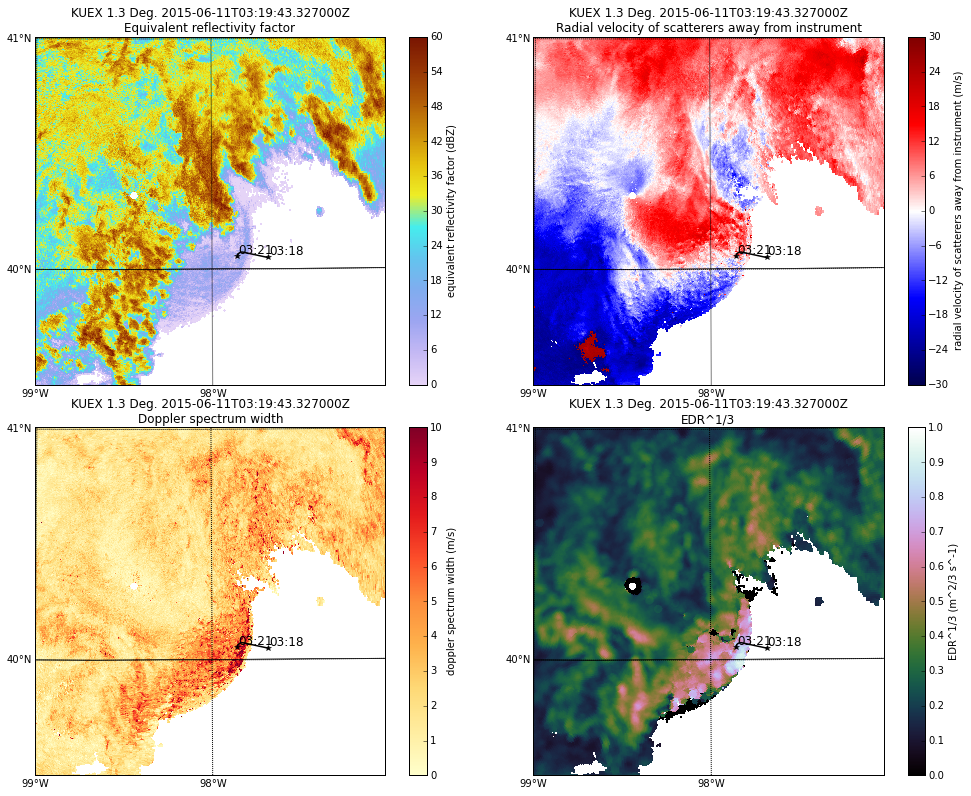

In [19]:
plot_list_of_fields_to_map(radarKUEX, sweep=radsweep, 
                    lonlim=[lonl[0], lonl[1]], latlim=[latl[0], latl[1]],
                    fields=['REF', 'VEL', 'SW', 'turbulence'],
                    vmins=[0, -30, 0, 0], vmaxs=[60, 30, 10, 1.0], 
                    units=['dBZ', 'm/s', 'm/s', 'EDR^0.33'],
                    cmaps=['pyart_LangRainbow12', 'seismic', 'YlOrRd', 'cubehelix'],
                    start_time=flight_squeeze[0], end_time=flight_squeeze[1],
                    plot_track=True, flight=flight1Hz,
                    plot_time_stamps=True, timestep=180)

If we squeeze the access on the flight data down to a 2-minute time frame, we can get to the good stuff!<br>
Increased turbulence became apparent at the maximum updraft associated with the leading edge of boundary arount 03:20:15.<br>
After this, we see when passing the over the outflow boundary we observed a series of oscillations in altitude via up- and downdrafts associated with the boundary in relatively smooth fashion until approximately 03:20:48.<br>
Within 1 second (and probably less as data rate is limited) the aircraft experienced +25 to -6.5 m/s updraft/downdraft couplet. The resulting  "bump" was approximately -1.8g!

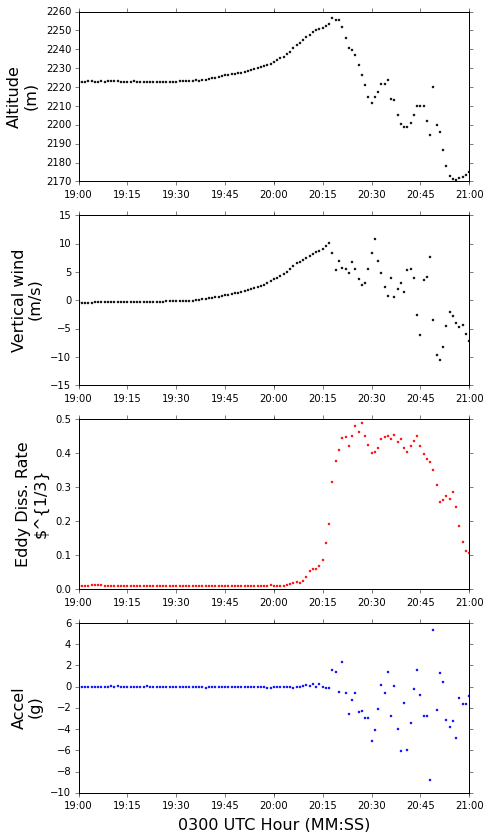

In [20]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(7, 14))
flight_event = ["2015-06-11 03:19:00", "2015-06-11 03:21:00"]
fl = FlightLevel(flight1Hz, basemap=None)
fl.plot_timeseries('altitude', color='k', marker='o', msize=2., lw=2,
                    dForm='%M:%S', tz=None, xdate=True,
#                    date_MinTicker='minute', other_MajTicks=None, other_MinTicks=None,
#                    other_min=None, other_max=None, 
                    start_time=flight_event[0], end_time=flight_event[1],
                    title=None, ylab='Altitude\n(m)', ax=ax1)

fl.plot_timeseries('Wwind', color='k', ylab='Vertical wind\n(m/s)', msize=2., 
                   start_time=flight_event[0], end_time=flight_event[1], 
                   dForm='%M:%S', ax=ax2)
fl.plot_timeseries('turb', color='r', ylab='Eddy Diss. Rate\n$^{1/3}', msize=2.,
                   start_time=flight_event[0], end_time=flight_event[1],  
                   dForm='%M:%S', ax=ax3)
fl.plot_timeseries('g_accel', color='b', xlab='0300 UTC Hour (MM:SS)', ylab='Accel\n(g)', msize=2.,
                   start_time=flight_event[0], end_time=flight_event[1],  
                   dForm='%M:%S', ax=ax4)

Let's take a closer look at just the EDR term zoomed in and changed the color map for fun and maybe(?) an easier view.

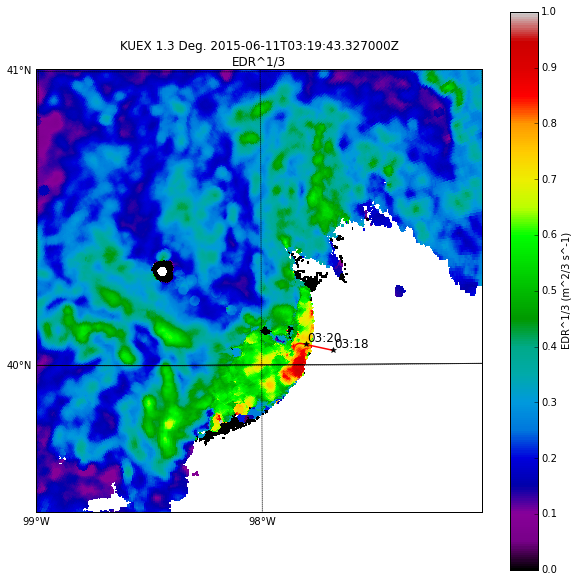

In [22]:
fig = plt.figure(figsize=(10.0, 10.))
displayKUEX = pyart.graph.RadarMapDisplay(radarKUEX)
displayKUEX.plot_ppi_map('turbulence', radsweep, vmin=0., vmax=1.,
            min_lon=lonl[0], max_lon=lonl[1], min_lat=latl[0], max_lat=latl[1],
            cmap='nipy_spectral',projection='aeqd', resolution='l',
            lat_0=radarKUEX.latitude['data'][0], lon_0=radarKUEX.longitude['data'][0])
f2 = FlightLevel(flight1Hz, basemap=displayKUEX.basemap)
f2.plot_trackmap(min_altitude=50., lw=2.5, track_color='red',
                start_time=flight_squeeze[0], end_time=flight_squeeze[1],)
f2.time_stamps(start_time=flight_squeeze[0], end_time=flight_squeeze[1],
                           labelspacing=120)

If we produce base scan plots, we can see the information available (only the radar reflectivity - top left) during the mission. From just this panel it appears that a boundary will be passed with the "hot echo" far enough behind to get in and out quickly with little chance of encountering anything severe. Having the spectrum width aboard, and post-event knowledge, it would be prudent to avoid this pocket. In fact a careful examination of the specific pocket along the northern side of the boundary is actually where the aircraft passed is probably the worst location that could have been passed for turbulence. The outflow boundary is deeper (seen by the fact that outbound motion is present through the lower 5 sweeps), while the southern end of the boundary is shallow. This depth then suggests that the more turbulent air has been lifted higher and in fact this upward motion may be causing elevated convection along the line. In fact in a later flight castellanus was observed in a similar situation and was avoided. It was only detected because of lightning backlighting the clouds.

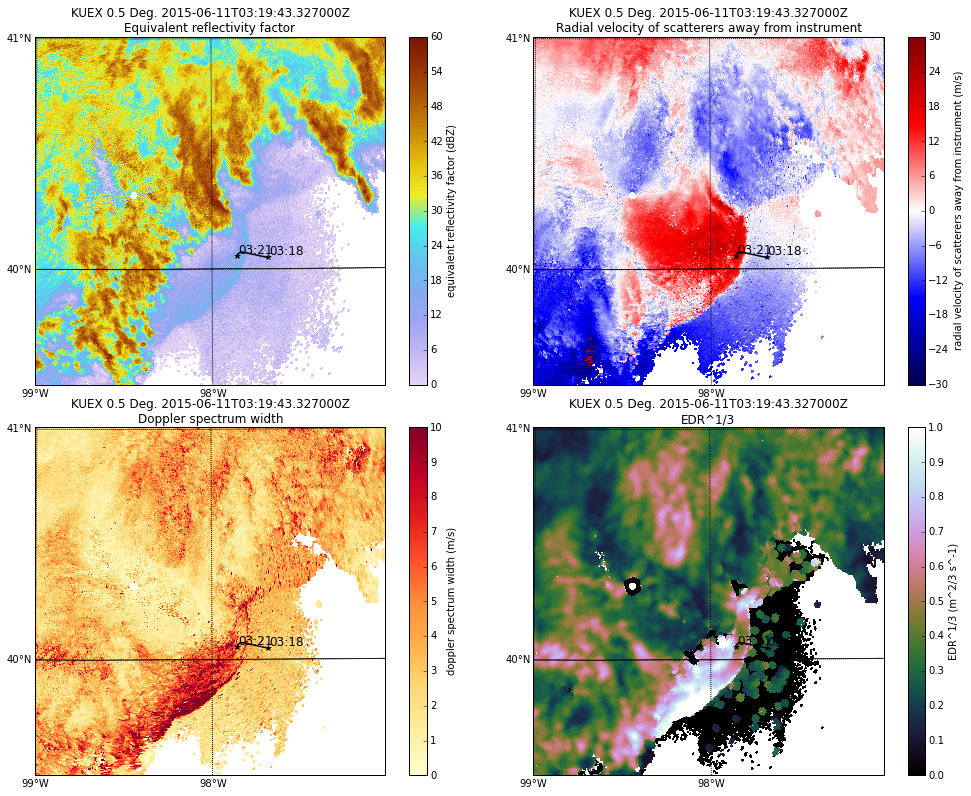

In [22]:
plot_list_of_fields_to_map(radarKUEX, sweep=0, 
                    lonlim=[lonl[0], lonl[1]], latlim=[latl[0], latl[1]],
                    fields=['REF', 'VEL', 'SW', 'turbulence'],
                    vmins=[0, -30, 0, 0], vmaxs=[60, 30, 10, 1.0], 
                    units=['dBZ', 'm/s', 'm/s', 'EDR^0.33'],
                    cmaps=['pyart_LangRainbow12', 'seismic', 'YlOrRd', 'cubehelix'],
                    start_time=flight_squeeze[0], end_time=flight_squeeze[1],
                    plot_track=True, flight=flight1Hz,
                    plot_time_stamps=True, timestep=180)

To get an idea of the vertical structure, we can create "RHIs" by grabbing data along azimuth angles using a Py-ART utility. We define a range of azimuths about the aircraft.

In [24]:
azimuths = [112, 115, 118, 121, 124, 127, 130]
rnglim, htlim, reflim, turblim = (0., 75.), (0., 5.), (0., 60.), (0., 1.)

Plotting a radial RHI every 6 degrees confirms that the EDR term is increased aloft as speculated above at the location of the aircraft (using the approximately 58 km distance calculated previously). It also suggests that a distinctive echo is not present (only a true RHI might reveal more) aloft. This suggests cloud formation (the flight crew confirms entering cloud just before turbulence) with rapid development taking place.

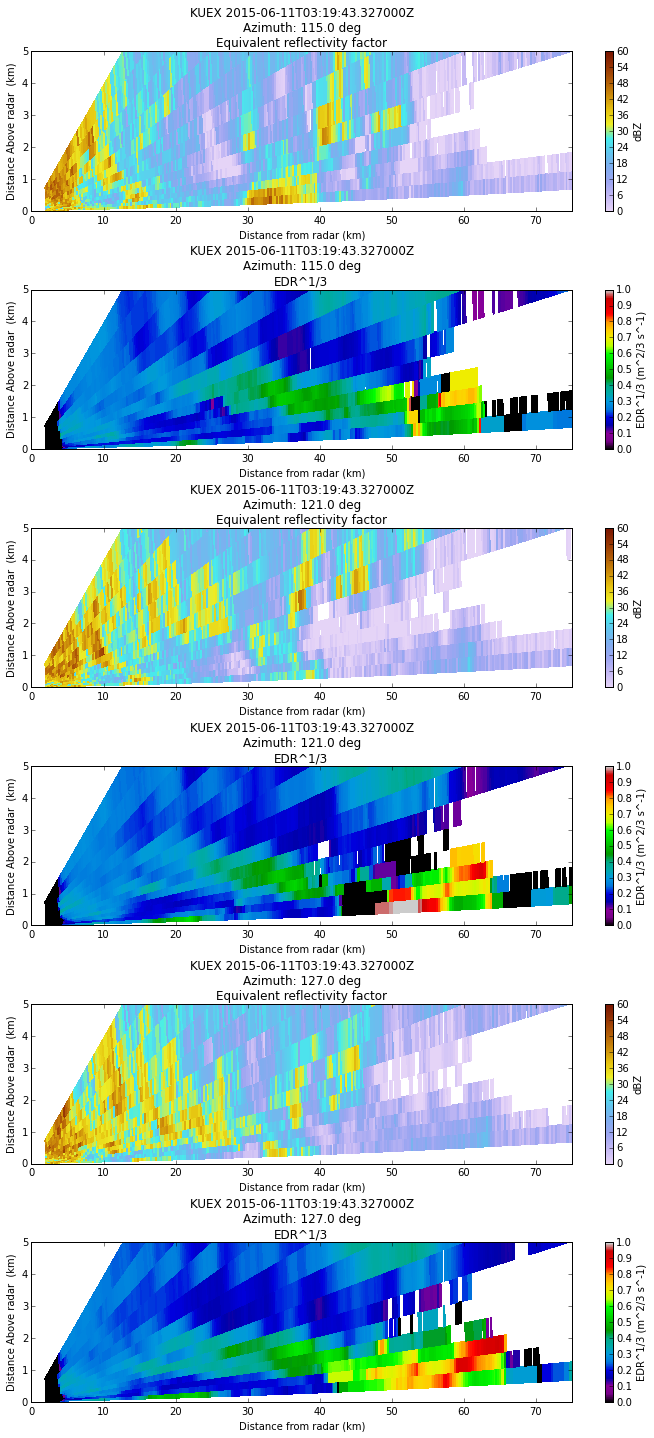

In [24]:
fig, (axXS1, axXS2, axXS3, axXS4, axXS5, axXS6) = plt.subplots(6, 1, figsize=(10,20))

disp = pyart.graph.RadarDisplay(radarKUEX)
disp.plot_azimuth_to_rhi('REF', azimuths[1], cmap='pyart_LangRainbow12',
              vmin=0., vmax=60., colorbar_label='dBZ', ax=axXS1)
disp.set_limits(rnglim, htlim, ax=axXS1)
disp.plot_azimuth_to_rhi('turbulence', azimuths[1], cmap='nipy_spectral',
              vmin=0., vmax=1., ax=axXS2)
disp.set_limits(rnglim, htlim, ax=axXS2)
disp.plot_azimuth_to_rhi('REF', azimuths[3], cmap='pyart_LangRainbow12',
              vmin=0., vmax=60., colorbar_label='dBZ', ax=axXS3)
disp.set_limits(rnglim, htlim, ax=axXS3)
disp.plot_azimuth_to_rhi('turbulence', azimuths[3], cmap='nipy_spectral',
              vmin=0., vmax=1., ax=axXS4)
disp.set_limits(rnglim, htlim, ax=axXS4)
disp.plot_azimuth_to_rhi('REF', azimuths[5], cmap='pyart_LangRainbow12',
              vmin=0., vmax=60., colorbar_label='dBZ', ax=axXS5)
disp.set_limits(rnglim, htlim, ax=axXS5) 
disp.plot_azimuth_to_rhi('turbulence', azimuths[5], cmap='nipy_spectral',
              vmin=0., vmax=1., ax=axXS6)
disp.set_limits(rnglim, htlim, ax=axXS6)
plt.tight_layout()

Looking at data from 10 minutes later shows the area behind the gust front filling in with increased convective activity. An equivalent look in the vertical also indicates deepening convection.

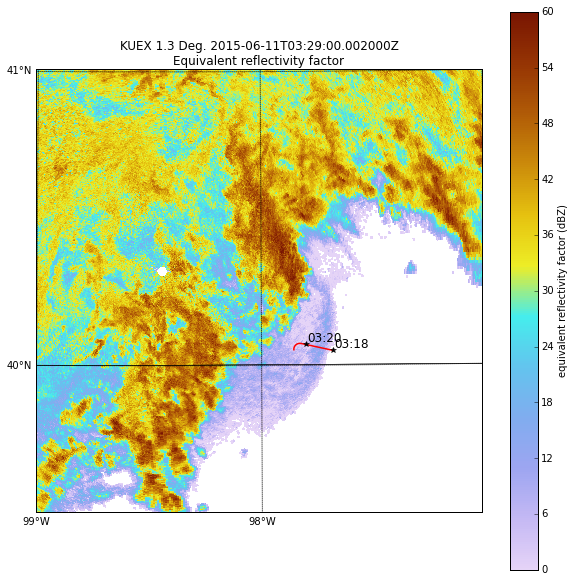

In [19]:
fig = plt.figure(figsize=(10.0, 10.))
display = pyart.graph.RadarMapDisplay(radarKUEXb)
#ax = fig.add_subplot(nrows, 2, index+1)
display.plot_ppi_map('REF', radsweep, vmin=0., vmax=60.,
            min_lon=lonl[0], max_lon=lonl[1], min_lat=latl[0], max_lat=latl[1],
            cmap='pyart_LangRainbow12',projection='aeqd', resolution='l',
            lat_0=radarKUEX.latitude['data'][0], lon_0=radarKUEX.longitude['data'][0])
f2 = FlightLevel(flight1Hz, basemap=display.basemap)
f2.plot_trackmap(min_altitude=50., lw=2.5, track_color='red',
                start_time=flight_squeeze[0], end_time=flight_squeeze[1],)
f2.time_stamps(start_time=flight_squeeze[0], end_time=flight_squeeze[1],
                           labelspacing=120)

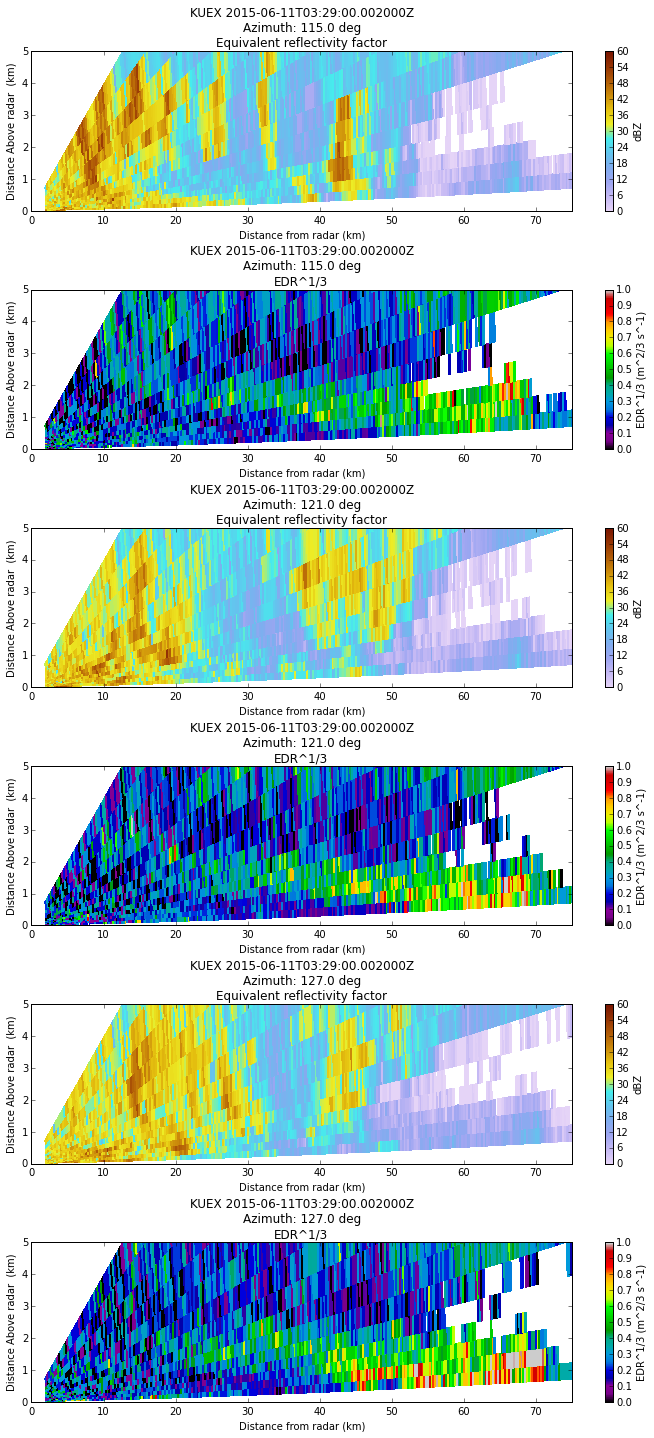

In [26]:
fig, (axXS1, axXS2, axXS3, axXS4, axXS5, axXS6) = plt.subplots(6, 1, figsize=(10,20))

disp = pyart.graph.RadarDisplay(radarKUEXb)
disp.plot_azimuth_to_rhi('REF', azimuths[1], cmap='pyart_LangRainbow12',
              vmin=0., vmax=60., colorbar_label='dBZ', ax=axXS1)
disp.set_limits(rnglim, htlim, ax=axXS1)
disp.plot_azimuth_to_rhi('turbulence', azimuths[1], cmap='nipy_spectral',
              vmin=0., vmax=1., ax=axXS2)
disp.set_limits(rnglim, htlim, ax=axXS2)
disp.plot_azimuth_to_rhi('REF', azimuths[3], cmap='pyart_LangRainbow12',
              vmin=0., vmax=60., colorbar_label='dBZ', ax=axXS3)
disp.set_limits(rnglim, htlim, ax=axXS3)
disp.plot_azimuth_to_rhi('turbulence', azimuths[3], cmap='nipy_spectral',
              vmin=0., vmax=1., ax=axXS4)
disp.set_limits(rnglim, htlim, ax=axXS4)
disp.plot_azimuth_to_rhi('REF', azimuths[5], cmap='pyart_LangRainbow12',
              vmin=0., vmax=60., colorbar_label='dBZ', ax=axXS5)
disp.set_limits(rnglim, htlim, ax=axXS5) 
disp.plot_azimuth_to_rhi('turbulence', azimuths[5], cmap='nipy_spectral',
              vmin=0., vmax=1., ax=axXS6)
disp.set_limits(rnglim, htlim, ax=axXS6) 
plt.tight_layout()

In [11]:
 def xy_to_latlon(radar):
    rng, az = np.meshgrid(radar.range['data'], radar.azimuth['data'])
    rng, ele = np.meshgrid(radar.range['data'], radar.elevation['data'])
    theta_e = ele * np.pi / 180.0       # elevation angle in radians.
    theta_a = az * np.pi / 180.0        # azimuth angle in radians.
    Re = 6371.0 * 1000.0 * 4.0 / 3.0     # effective radius of earth in meters.
    r = rng * 1000.0                    # distances to gates in meters.

    z = (r ** 2 + Re ** 2 + 2.0 * r * Re * np.sin(theta_e)) ** 0.5 - Re
    s = Re * np.arcsin(r * np.cos(theta_e) / (Re + z))  # arc length in m.
    x = s * np.sin(theta_a)
    y = s * np.cos(theta_a)

    c = np.sqrt(x*x + y*y) / r
    phi_0 = radar.latitude['data'] * np.pi / 180
    azi = np.arctan2(y, x)  # from east to north

    lat = np.arcsin(np.cos(c) * np.sin(phi_0) +
                    np.sin(azi) * np.sin(c) * np.cos(phi_0)) * 180 / np.pi
    lon = (np.arctan2(np.cos(azi) * np.sin(c), np.cos(c) * np.cos(phi_0) -
           np.sin(azi) * np.sin(c) * np.sin(phi_0)) * 180 /
            np.pi + radar.longitude['data'])
    lon = np.fmod(lon + 180, 360) - 180

    lat_axis = {
        'data':  lat,
        'long_name': 'Latitude for points in Cartesian system',
        'axis': 'YX',
        'units': 'degree_N',
        'standard_name': 'latitude',
    }

    lon_axis = {
        'data': lon,
        'long_name': 'Longitude for points in Cartesian system',
        'axis': 'YX',
        'units': 'degree_E',
        'standard_name': 'longitude',
    }
    return lat_axis, lon_axis

In [2]:
rKUEXawot = awot.util.pyart_radar_to_awot(radarKUEX)
lat, lon = xy_to_latlon(radarKUEX)
rKUEXawot['latitude'] = lat
rKUEXawot['longitude'] = lon

NameError: name 'awot' is not defined

[-97.68324992048565 -97.68423548360185 -97.68522082940821
 -97.68620596793582 -97.68719092244702 -97.68817565839689
 -97.68916018365402 -97.69014456637132 -97.69112882578385
 -97.69211293567517 -97.69309685025931 -97.69408054839082
 -97.69506403358733 -97.69604732907912 -97.69703044555787
 -97.69801350457752 -97.69899659229857 -97.69997968001248 -97.7009626790273
 -97.70194556668831 -97.70292836912894 -97.70391113235617
 -97.70489394926335 -97.70587682439515 -97.70685975973011 -97.7078427589502
 -97.70882584087678 -97.70980903995442 -97.71079236157364
 -97.71177577849416 -97.71275930631614 -97.71374297176087
 -97.71472674958576 -97.71571060816719 -97.71669457057196
 -97.71767866884072 -97.71866290296113 -97.71964722213526
 -97.72063158216574 -97.72161600842155 -97.72260052027745
 -97.72358511602692 -97.72456978339066 -97.72555455355271
 -97.72653942274216 -97.72752436785805 -97.72850935266118
 -97.72949435122798 -97.73047931238561 -97.73146419724148 -97.7324489695998
 -97.7334336044627

ValueError: setting an array element with a sequence.

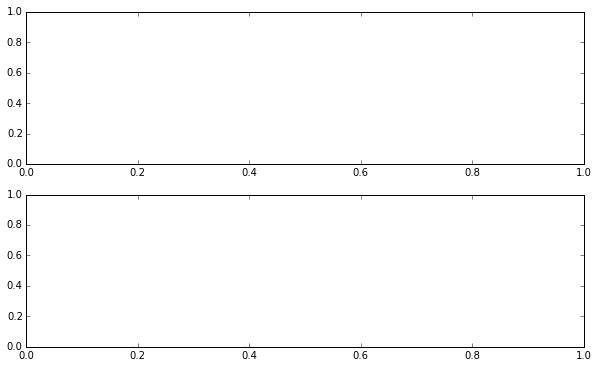

In [25]:
fig, (axXS1, axXS2) = plt.subplots(2, 1, figsize=(10,6))
f = FlightLevel(flight1Hz, basemap=displayKUEX.basemap)
f.plot_radar_cross_section(rKUEXawot, 'REF', cmap='pyart_LangRainbow12', cminmax=reflim,
                           start_time=flight_squeeze[0], end_time=flight_squeeze[1], ax=axXS1)
f.plot_radar_cross_section(rKUEXawot, 'turbulence', cmap='nipy_spectral', cminmax=turblim,
                           start_time=flight_squeeze[0], end_time=flight_squeeze[1], ax=axXS1)

In [28]:
fname1, fext1 = os.path.split(files[13])
fname1, fext1 = os.path.split(files[5])
pyart.io.write_cfradial(fname'_with_turbulence'+fext, radar)
pyart.io.write_cfradial(fname'_with_turbulence'+fext, radar2)

SyntaxError: invalid syntax (<ipython-input-28-eb3f3db12f84>, line 3)

In [1]:
print(lat['data'].shape, rKUEXawot['fields']['REF']['data'].shape)

NameError: name 'lat' is not defined